In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.mlab
import scipy.io.wavfile
import scipy
import scipy.fftpack
import pandas as pd
import time
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
dataset = pd.read_csv('/home/husein/space/UrbanSound8K/metadata/UrbanSound8K.csv')
dataset.slice_file_name = 'audio/fold' + dataset.fold.astype(str) + '/' + dataset.slice_file_name
dataset = dataset.iloc[np.random.permutation(len(dataset))]
dataset.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
7190,audio/fold3/63095-4-1-27.wav,63095,93.353862,97.353862,1,3,4,drilling
182,audio/fold1/103074-7-3-0.wav,103074,46.632637,50.632637,1,1,7,jackhammer
894,audio/fold10/118278-4-0-9.wav,118278,4.500000,8.500000,2,10,4,drilling
7684,audio/fold4/7389-1-4-10.wav,7389,165.761242,169.761242,2,4,1,car_horn
4686,audio/fold9/188823-7-2-3.wav,188823,28.138791,32.138791,1,9,7,jackhammer


In [3]:
unique_sound = np.unique(dataset.iloc[:, -1])
unique_sound

array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music'], dtype=object)

In [4]:
# define our global variables
learning_rate = 0.001
sound_dimension = [64, 512]
batch_size = 128
epoch = 20

In [5]:
def processAudio(audio_file):
    rate, data = scipy.io.wavfile.read(audio_file)
    try:
        if data.shape[1]:
            data = np.mean(data, axis = 1)
    except:
        pass
    audio = scipy.fftpack.fft(data)
    audio = scipy.fftpack.fftshift(audio)
    log_amp_spectrum = np.log10(np.abs(audio))
    audio = matplotlib.mlab.specgram(log_amp_spectrum)[0]
    return np.expand_dims(scipy.misc.imresize(audio, sound_dimension), axis = 2)

In [6]:
class Model:

    def __init__(self, size_output):
        self.X = tf.placeholder('float', [None, sound_dimension[0], sound_dimension[1], 1])
        self.Y = tf.placeholder('float', [None, size_output])

        def conv_layer(x, conv, out_shape, name, stride = 1):
            w = tf.Variable(tf.truncated_normal([conv, conv, int(x.shape[3]), out_shape]), name = name + '_w')
            b = tf.Variable(tf.truncated_normal([out_shape], stddev = 0.01), name = name + '_b')
            return tf.nn.conv2d(x, w, [1, stride, stride, 1], padding = 'SAME') + b
        
        def fully_connected(x, out_shape, name):
            w = tf.Variable(tf.truncated_normal([int(x.shape[1]), out_shape]), name = name + '_fc_w')
            b = tf.Variable(tf.truncated_normal([out_shape], stddev = 0.01), name = name + '_fc_b')
            return tf.matmul(x, w) + b

        def pooling(x, k = 2, stride = 2):
            return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, stride, stride, 1], padding = 'SAME')

        with tf.name_scope("conv5-16"):
            conv1 = tf.nn.relu(conv_layer(self.X, 5, 16, '16'))

        with tf.name_scope("maxpool-1"):
            pooling1 = pooling(conv1)

        with tf.name_scope("conv5-32"):
            conv2 = tf.nn.relu(conv_layer(pooling1, 5, 16, '16'))

        with tf.name_scope("maxpool-2"):
            pooling2 = pooling(conv2)

        with tf.name_scope("conv5-64"):
            conv3 = tf.nn.relu(conv_layer(pooling2, 5, 64, '64'))

        with tf.name_scope("maxpool-3"):
            pooling3 = pooling(conv3)

        with tf.name_scope("conv5-128"):
            conv4 = tf.nn.relu(conv_layer(pooling3, 5, 128, '128'))

        with tf.name_scope("maxpool-4"):
            pooling4 = pooling(conv4)
        
        output_shape = int(pooling4.shape[1]) * int(pooling4.shape[2]) * int(pooling4.shape[3])
        
        with tf.name_scope("fc-512"):
            pooling4 = tf.reshape(pooling4, [-1, output_shape])
            fc1 = tf.nn.relu(fully_connected(pooling4, 512, '512'))

        with tf.name_scope("fc-128"):
            fc2 = tf.nn.relu(fully_connected(fc1, 128, '128'))

        with tf.name_scope("logits"):
            self.logits = fully_connected(fc2, size_output, 'logits')
            
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.Y))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [7]:
no_classes = np.unique(dataset['classID']).shape[0]
sess = tf.InteractiveSession()
model = Model(no_classes)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.global_variables())

train_dataset = dataset.iloc[:int(dataset.shape[0] * 0.80), :]
test_dataset = dataset.iloc[int(dataset.shape[0] * 0.80):, :]

In [8]:
ACCURACY, LOST = [], []
for i in range(epoch):
    last = time.time()
    total_acc, total_loss = 0, 0
    for k in range(0, (train_dataset.shape[0] // batch_size) * batch_size, batch_size):
        batch_x, batch_y = [], []
        for n in range(batch_size):
            try:
                batch_x.append(processAudio(train_dataset.slice_file_name.iloc[k + n]))
                onehot = np.zeros((no_classes))
                onehot[train_dataset.classID.iloc[k + n]] = 1.0
                batch_y.append(onehot)
            except Exception as e:
                continue
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        loss, _ = sess.run([model.cost, model.optimizer], feed_dict = {model.X: batch_x, model.Y: batch_y})
        total_acc += sess.run(model.accuracy, feed_dict = {model.X: batch_x, model.Y: batch_y})
        total_loss += loss
    total_loss /= (train_dataset.shape[0] // batch_size)
    total_acc /= (train_dataset.shape[0] // batch_size)
    ACCURACY.append(total_acc)
    LOST.append(total_loss)
    print('epoch: ', i + 1, 'avg loss: ', total_loss, 'avg acc: ', total_acc, 'avg time: ', (time.time() - last) / (train_dataset.shape[0] // batch_size))

('epoch: ', 1, 'avg loss: ', 639422785.18518519, 'avg acc: ', 0.19716438761463873, 'avg time: ', 6.869770963986714)
('epoch: ', 2, 'avg loss: ', 139849726.37037036, 'avg acc: ', 0.29842291468823395, 'avg time: ', 6.536748705086885)
('epoch: ', 3, 'avg loss: ', 93028092.222222224, 'avg acc: ', 0.36300998705404774, 'avg time: ', 6.537040648636995)
('epoch: ', 4, 'avg loss: ', 90252430.222222224, 'avg acc: ', 0.37186967802268489, 'avg time: ', 6.53545003467136)
('epoch: ', 5, 'avg loss: ', 68100667.555555552, 'avg acc: ', 0.42427944750697527, 'avg time: ', 6.530538055631849)
('epoch: ', 6, 'avg loss: ', 69304702.148148149, 'avg acc: ', 0.40987019351235143, 'avg time: ', 6.523895497675295)
('epoch: ', 7, 'avg loss: ', 61631381.185185187, 'avg acc: ', 0.44965207080046338, 'avg time: ', 6.522541425846241)
('epoch: ', 8, 'avg loss: ', 50620412.888888888, 'avg acc: ', 0.46966591753341536, 'avg time: ', 6.524025978865446)
('epoch: ', 9, 'avg loss: ', 48619866.111111112, 'avg acc: ', 0.476513837

In [9]:
batch_x, batch_y, labels = [], [], []
for n in range(128):
    try:
        batch_x.append(processAudio(test_dataset.slice_file_name.iloc[n]))
        onehot = np.zeros((no_classes))
        onehot[test_dataset.classID.iloc[n]] = 1.0
        batch_y.append(onehot)
        labels.append(test_dataset.classID.iloc[n])
    except Exception as e:
        continue
batch_x = np.array(batch_x)
batch_y = np.array(batch_y)
acc, logits = sess.run([model.accuracy, tf.cast(tf.argmax(model.logits, 1), tf.int32)], feed_dict = {model.X : batch_x, model.Y : batch_y})
print 'testing accuracy: ' + str(acc)
print(metrics.classification_report(labels, logits, target_names = np.unique(unique_sound)))

testing accuracy: 0.467391
                  precision    recall  f1-score   support

 air_conditioner       0.40      0.29      0.33         7
        car_horn       0.00      0.00      0.00         7
children_playing       0.43      0.30      0.35        10
        dog_bark       1.00      0.29      0.44         7
        drilling       0.33      1.00      0.50        13
   engine_idling       1.00      0.44      0.62         9
        gun_shot       0.67      0.50      0.57         4
      jackhammer       1.00      0.50      0.67        14
           siren       0.62      0.80      0.70        10
    street_music       0.17      0.18      0.17        11

     avg / total       0.57      0.47      0.45        92



/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


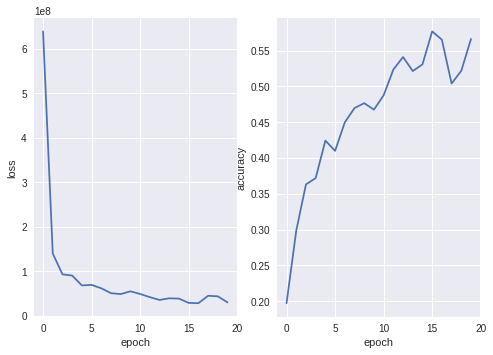

In [10]:
EPOCH = np.arange(len(LOST))
plt.subplot(1, 2, 1)
plt.plot(EPOCH, LOST)
plt.xlabel('epoch'); plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACCURACY)
plt.xlabel('epoch'); plt.ylabel('accuracy')
plt.show()